In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load in a sample data set. These are the VLT/FORS2 600B spectroscopic light curves which were used in Fortune et al. 2023. The data reduction closely follows the reduction in Gibson et al. 2017 in the original analysis of the data. The observations are publicly available in the ESO Science Archive Facility (http://archive.eso.org) under ESO programme 096.C-0765.

In [3]:
data_save_name = f"WASP31b_FORS2_600B"
data_folder = os.path.join("sample_data", data_save_name)

x_l = np.load(os.path.join(data_folder, f"x_l.npy"))                # Wavelengths of bin centres in angstrom
x_t = np.load(os.path.join(data_folder, f"x_t.npy"))                # Time points in HJD
Y = np.load(os.path.join(data_folder, f"Y.npy"))                    # Normalised relative flux values (relative to comparison star)
ld_coeff = np.load(os.path.join(data_folder, f"ld_coeff.npy"))      # Mean limb-darkening coefficients from PyLDTk
#ld_coeff_errs = np.load(os.path.join(data_folder, f"ld_coeff_errs.npy")) # Standard deviation of limb-darkening coefficients from PyLDTk

# Define number of wavelength and time points
N_l = x_l.size
N_t = x_t.size

First use the package jaxoplanet to write a 1D transit light curve mean function:

In [17]:
from jaxoplanet.orbits import KeplerianOrbit
from jaxoplanet.light_curves import QuadLightCurve

jax.config.update("jax_enable_x64", True)

def transit_light_curve(mf_params, x_t):
    light_curve = QuadLightCurve.init(u1=mf_params["c1"], u2=mf_params["c2"])
    orbit = KeplerianOrbit.init(
        time_transit=mf_params["T0"],
        period=mf_params["P"],
        semimajor=mf_params["a"],
        impact_param=mf_params["b"],
        radius=jnp.sqrt(mf_params["rho_sq"]),
    )
    
    flux = (mf_params["Foot"] + 24*mf_params["Tgrad"]*(x_t-mf_params["T0"]))*(1+light_curve.light_curve(orbit, x_t)[0])
    
    return flux


Here is an example generating a 1D light curve using literature values for WASP-31b from Anderson et al. 2010 with the FORS2 observation overplotted

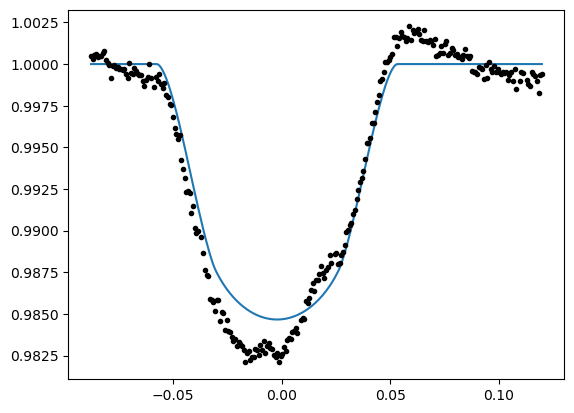

In [21]:
mfp_1D = {"T0":       -0.0021,       # Central transit time
          "P":        3.4059095,    # Period
          "a":        8.19,         # System scale aka a/Rs
          "b":        0.761,        # Impact parameter
          "rho_sq":   0.12546**2, # Transit depth (given as radius ratio (rho) squared)
          "c1":       ld_coeff[0, 0],          # First quadratic limb darkening coefficient
          "c2":       ld_coeff[0, 1],          # Second quadratic limb darkening coefficient
          "Foot":     1.,         # Flux out-of-transit aka baseline flux
          "Tgrad":    0.}         # Gradient of baseline flux

plt.plot(x_t, transit_light_curve(mfp_1D, x_t))
plt.plot(x_t, Y.mean(0), 'k.')
plt.show()

If we want to use this function to fit multiple light curves simultaneously a simple approach would be to write a for loop which goes through each of the wavelength-dependent parameters and plots a light curve for each wavelength. JAX provides a very efficient way of doing this, we can use the vmap function to "vectorise" this to two dimensions.

In [22]:
transit_light_curve_vmap = jax.vmap(transit_light_curve, in_axes=({"T0":None, "P":None, "a":None, "rho_sq":0, "b":None,
                                                                   "c1":0, "c2":0, "Foot":0, "Tgrad":0}, None), out_axes = 0)

def transit_2D(p, x_l, x_t):
    transit_params = ["T0", "P", "a", "rho_sq", "b", "c1", "c2", "Foot", "Tgrad"]
    
    mfp = {k:p[k] for k in transit_params}
    
    return transit_light_curve_vmap(mfp, x_t)
transit_2D.mfp = ["T0", "P", "a", "rho_sq", "b", "c1", "c2", "Foot", "Tgrad"]

Here is an example generating multiple spectroscopic light curves. Note that some of the parameters are now arrays of the same dimension as the number of light curves, whereas others are wavelength-independent and are only size 1 arrays (while not necessary for this function, luas assumes even single parameters will be size 1 arrays instead of scalars).

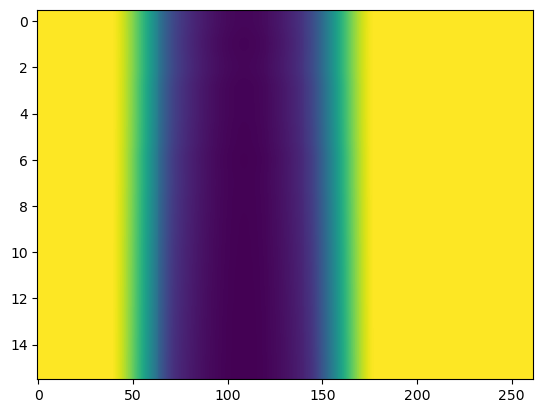

In [25]:
mfp = {"T0":      -0.0021*np.ones(1),       # Central transit time
       "P":        3.4059095*np.ones(1),    # Period
       "a":        8.19*np.ones(1),         # System scale aka a/Rs
       "b":        0.761*np.ones(1),        # Impact parameter
       "rho_sq":   0.12546**2*np.ones(N_l), # Transit depth (given as radius ratio (rho) squared)
       "c1":       ld_coeff[:, 0],          # First quadratic limb darkening coefficient
       "c2":       ld_coeff[:, 1],          # Second quadratic limb darkening coefficient
       "Foot":     1.*np.ones(N_l),         # Flux out-of-transit aka baseline flux
       "Tgrad":    0.*np.ones(N_l)}         # Gradient of baseline flux

plt.imshow(transit_2D(mfp, x_l, x_t), aspect = 'auto')
plt.show()

Now that we have our mean function, let's work on building our kernel function. We will use the same kernel function as used in Fortune et al. 2023 which was:

\begin{align}
        \mathbf{K}_{ij} = h_\mathrm{CM}^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda_\mathrm{CM}}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + h_\mathrm{WSS; \lambda_i}^2 \delta_{\lambda_i \lambda_j} \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + h_\mathrm{HFS}^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda_\mathrm{HFS}}^2}\right) \delta_{t_i t_j} + \sigma_\mathrm{\lambda_i}^2\delta_{\lambda_i \lambda_j} \delta_{t_i t_j}
\end{align}


\begin{align}
        \mathbf{K}_{ij} = \left[h_\mathrm{CM}^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda_\mathrm{CM}}^2}\right) + h_\mathrm{WSS; \lambda_i}^2 \delta_{\lambda_i \lambda_j}\right] \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + \left[h_\mathrm{HFS}^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda_\mathrm{HFS}}^2}\right) + \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j}\right] \delta_{t_i t_j}
\end{align}

We can write this in the form of $\mathbf{K}_\lambda \otimes \mathbf{K}_t + \mathbf{\Sigma}_\lambda \otimes \mathbf{\Sigma}_t$ as:
\begin{align}
    \mathbf{K}_\lambda &= h_\mathrm{CM}^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda_\mathrm{CM}}^2}\right) + h_\mathrm{WSS; \lambda_i}^2 \delta_{\lambda_i \lambda_j}\\
    \mathbf{K}_t &= \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) \\
    \mathbf{\Sigma}_\lambda &= h_\mathrm{HFS}^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda_\mathrm{HFS}}^2}\right) + \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j}\\
    \mathbf{\Sigma}_t &= \delta_{t_i t_j}
\end{align}

First we can import the evaluate_kernel function to build a kernel in JAX and choose from a selection of prewritten kernels in kernel_functions.py

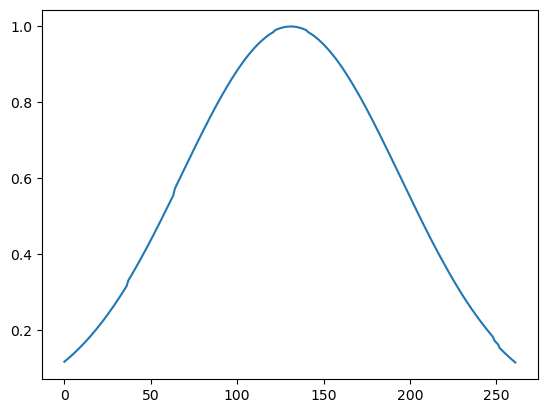

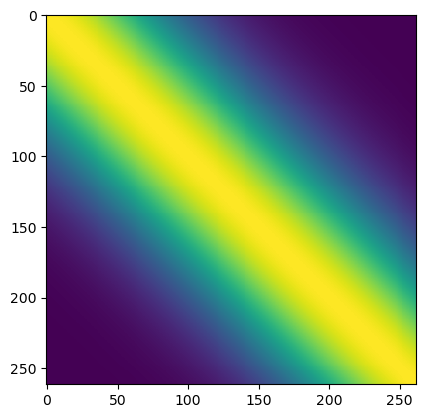

In [40]:
from kernel_functions import evaluate_kernel, rbf_kernel

K_t_sqexp = evaluate_kernel(rbf_kernel, x_t, x_t, 0.05)

plt.plot(K_t_sqexp[:, N_t//2])
plt.show()

plt.imshow(K_t_sqexp)
plt.show()

Now let's describe how to build each of our four covariance matrices, each is a combination of a squared-exponential kernel and/or terms added to the diagonal. We will need to use the Kernel object from KernelClass and set each of these functions as methods of it for use with the luas GP object.

In [41]:
from KernelClass import Kernel

def Kl_VLT(hp, x_l1, x_l2, wn = True):
    
    Kl = hp["h_CM"]**2 * evaluate_kernel(rbf_kernel, x_l1, x_l2, hp["l_l_CM"])
    
    Kl += jnp.diag(hp["h_WSS"]**2)
    
    return Kl
Kl_VLT.hp = ["h_CM", "h_WSS", "l_l_CM"]
Kl_VLT.diag = False


def Kt_VLT(hp, x_t1, x_t2, wn = True):
    
    Kt = evaluate_kernel(rbf_kernel, x_t1, x_t2, hp["l_t"])
    
    return Kt
Kt_VLT.hp = ["l_t"]
Kt_VLT.diag = False


def Sl_VLT(hp, x_l1, x_l2, wn = True):
    
    Sl = hp["h_HFS"]**2 * evaluate_kernel(rbf_kernel, x_l1, x_l2, hp["l_l_HFS"])
    
    if wn:
        Sl += jnp.diag(jnp.square(hp["sigma"]))
    
    return Sl
Sl_VLT.hp = ["h_HFS", "l_l_HFS", "sigma"]
Sl_VLT.diag = False


def St_VLT(hp, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.size)
St_VLT.hp = []
St_VLT.diag = True


VLT_kernel = Kernel()
VLT_kernel.Kl = Kl_VLT
VLT_kernel.Kt = Kt_VLT
VLT_kernel.Sl = Sl_VLT
VLT_kernel.St = St_VLT

Now let's use the mean function and kernel functions we have defined to create a luas GP object for which we can efficiently calculate the log-likelihood and it's derivatives as well as the GP predictive mean and covariance of the data.

Starting logL:  23193.794873630795


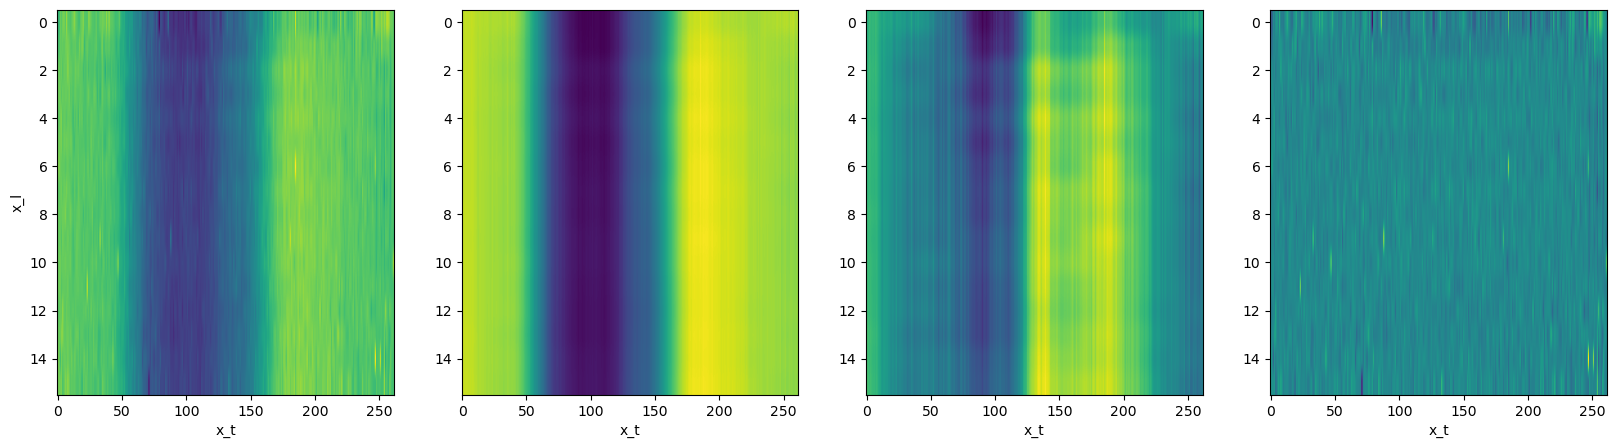

In [42]:
from GP_Class import GP

initial_params = {"T0":      -0.0021*np.ones(1),       # Central transit time
                  "P":        3.4059095*np.ones(1),    # Period
                  "a":        8.19*np.ones(1),         # System scale aka a/Rs
                  "b":        0.761*np.ones(1),        # Impact parameter
                  "rho_sq":   0.12546**2*np.ones(N_l), # Transit depth (given as radius ratio (rho) squared)
                  "c1":       ld_coeff[:, 0],          # First quadratic limb darkening coefficient
                  "c2":       ld_coeff[:, 1],          # Second quadratic limb darkening coefficient
                  "Foot":     1.*np.ones(N_l),         # Flux out-of-transit aka baseline flux
                  "Tgrad":    0.*np.ones(N_l),         # Gradient of baseline flux
                  "h_CM":     1.5e-3*np.ones(1),       # Height scale of common-mode systematics
                  "l_t":      0.011*np.ones(1),        # Time length scale for both common-mode and wavelength-specific systematics
                  "l_l_CM":   10000*np.ones(1),        # Wavelength length scale of "common-mode" systematics
                  "sigma":    1.2e-3*np.ones(N_l),     # White noise amplitudes (wavelength-dependent)
                  "h_WSS":    2e-4*np.ones(N_l),       # Height scales of wavelength-specific systematics
                  "h_HFS":    3e-4*np.ones(1),         # Height scale of high-frequency systematics
                  "l_l_HFS":  1000*np.ones(1)}         # Wavelength length scale of high-frequency systematics

# Set parameters for which the logarithm (base 10) will be fit for
log_params = ["h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS"]

# Transform these parameters to log values before inputting
for name in log_params:
    initial_params[name] = np.log10(initial_params[name])

# State which mean function parameters will be varied (for knowing which parameters to calculate gradients/hessian with respect to)
mfp_to_vary = ["T0", "rho_sq", "c1", "c2", "Foot", "Tgrad", "a", "b"]

# State which hyperparameters will be varied (for same reason)
hp_to_vary = ["h_CM", "l_l_CM", "l_t", "h_WSS", "h_HFS", "l_l_HFS", "sigma"]

# Initialise GP object
gp = GP(initial_params, mfp_to_vary, hp_to_vary, x_l, x_t, Y,
        VLT_kernel, mf = transit_2D, log_params = log_params)

print("Starting logL: ", gp.logL(gp.p))
gp.plot(gp.p)

Gradients of the log-likelihood can be calculated as:

In [44]:
gp.grad_logL(gp.p)

{'Foot': DeviceArray([-30226.56498897, -28318.42279315,  12112.60082885,
               -4474.3302219 ,  16368.40689416,  -1393.6298602 ,
                7274.54489652,  14924.87307   ,   8197.72063711,
                9452.75089085,  13649.50553796,  -4484.40158837,
              -10946.31405105, -11243.77308515,    777.53765935,
                7510.43323162], dtype=float64),
 'T0': DeviceArray([-940.46906886], dtype=float64),
 'Tgrad': DeviceArray([-22067.76788403, -13396.85483174,   8669.36895011,
                1738.18358651,  15045.52223362,   5861.27914067,
                5561.5084271 ,   8282.14874797,   2788.87060237,
                6067.03775211,  -1212.32006038,  -2203.57963367,
               -7090.0313303 ,   -279.96876006,  -5578.76713732,
               -1183.69669208], dtype=float64),
 'a': DeviceArray([10.02183077], dtype=float64),
 'b': DeviceArray([-15.52272273], dtype=float64),
 'c1': DeviceArray([-102.73415025,  -82.03549989,   49.85878696,  -32.96565827,
      

The hessian of the log-likelihood can be calculated as:

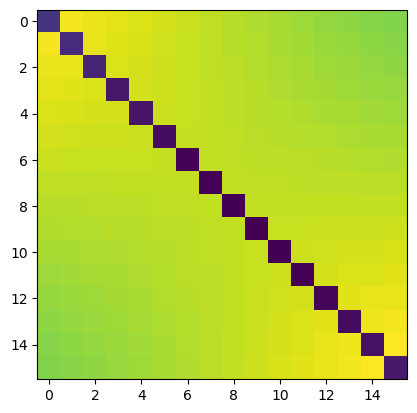

In [52]:
hess = gp.hessian_logL(gp.p)
plt.imshow(hess["rho_sq"]["rho_sq"])
plt.show()

There are also functions for the log-likelihood and gradient of the log-likelihood which take an array of parameters as input (found by using jax.flatten_util.ravel_pytree on the dictionary of parameter values) and for the gradients will also output an array of gradients in the same ordering as the inputs. This can be useful for implementation with PyMC or other packages.

In [54]:
logL = gp.logL_arr(gp.p_arr)
grad_logL = gp.grad_logL_arr(gp.p_arr)

print("Array of gradients: ", grad_logL)

# Convert back to a dictionary
grad_dict = gp.make_p_dict(grad_logL)

print("Dictionary of gradients: ", grad_dict)

Array of gradients:  [-3.02265650e+04 -2.83184228e+04  1.21126008e+04 -4.47433022e+03
  1.63684069e+04 -1.39362986e+03  7.27454490e+03  1.49248731e+04
  8.19772064e+03  9.45275089e+03  1.36495055e+04 -4.48440159e+03
 -1.09463141e+04 -1.12437731e+04  7.77537659e+02  7.51043323e+03
 -9.40469069e+02 -2.20677679e+04 -1.33968548e+04  8.66936895e+03
  1.73818359e+03  1.50455222e+04  5.86127914e+03  5.56150843e+03
  8.28214875e+03  2.78887060e+03  6.06703775e+03 -1.21232006e+03
 -2.20357963e+03 -7.09003133e+03 -2.79968760e+02 -5.57876714e+03
 -1.18369669e+03  1.00218308e+01 -1.55227227e+01 -1.02734150e+02
 -8.20354999e+01  4.98587870e+01 -3.29656583e+01  4.69327776e+01
  9.89536301e+00 -2.51259631e+00  5.05814318e+01  3.62297502e+01
  1.64187819e+01  4.32840282e+01 -1.62306296e+01 -3.34436372e+01
 -3.55859774e+01  1.15106200e+01  2.55436023e+01 -5.48010174e+01
 -4.32376941e+01  2.84791824e+01 -2.23293553e+01  2.06161119e+01
  1.18909714e+01 -7.10557761e+00  2.96955360e+01  2.42622954e+01
  4.

The GP mean and uncertainty (in standard deviations) can be calculated using GP.predict:

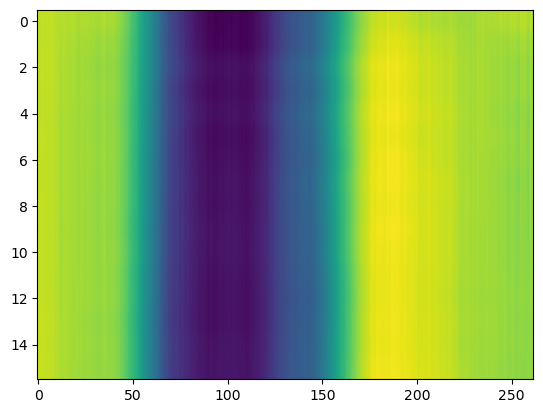

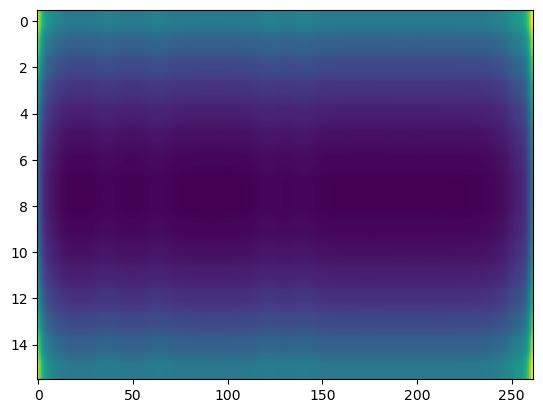

In [60]:
gp_mean, gp_cov, M = gp.predict(gp.p)

plt.imshow(gp_mean, aspect = 'auto')
plt.show()

plt.imshow(gp_cov, aspect = 'auto')
plt.show()